In [1]:
from load_data import parameters_dict, simulation_file_paths

import numpy as np
# import saved feature array
feature_arr = np.load("feature_arr.npy")

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples


def silhouette_score_mod(feature_arr, labels):
    n_clusters = len(set(labels))
    sample_silhouette_values = silhouette_samples(feature_arr, labels)
    score_mod = 0
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        max_silhouette = ith_cluster_silhouette_values[-1]
        if max_silhouette > silhouette_score(feature_arr, labels):
            score_mod += 1

        score_mod = score_mod/float(n_clusters)
        return score_mod
    

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Compute DBSCAN
db = DBSCAN(eps=0.64, min_samples=10).fit(feature_arr)
silhouette_score_ = silhouette_score(feature_arr, db.labels_)
print(silhouette_score_)
silhouette_score_mod(feature_arr, db.labels_)
print(silhouette_score_mod(feature_arr, db.labels_))

0.41656822
0.047619047619047616


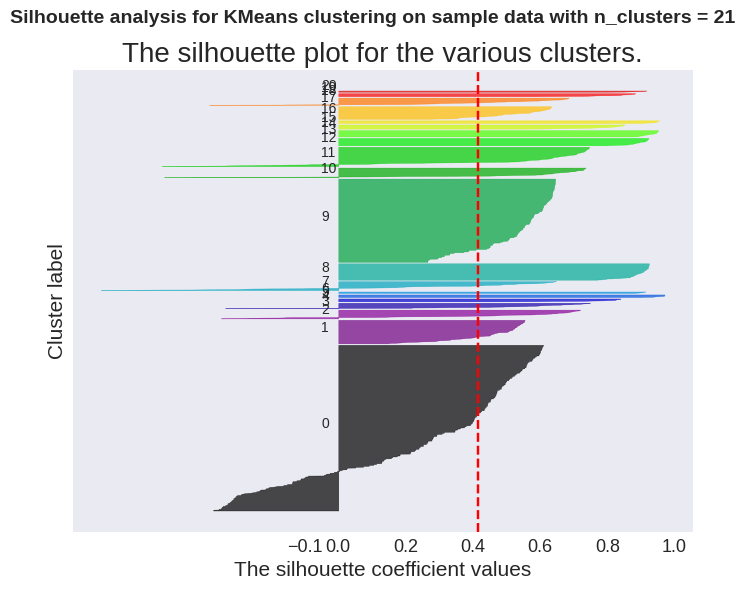

In [31]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

n_clusters = len(set(db.labels_))
cluster_labels = db.labels_

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(feature_arr, cluster_labels)
sample_silhouette_values = silhouette_samples(feature_arr, cluster_labels)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [11]:
# hyperparameter optimization
import optuna


def objective(trial):
    eps = trial.suggest_float("eps", 0.5, 1.5)
    min_samples = trial.suggest_int("min_samples", 2, 10)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_arr)
    score = silhouette_score(feature_arr, labels)
    score_mod = silhouette_score_mod(feature_arr, labels)
    return score, score_mod


# search_space = {"eps": (0.5, 1.5), "min_samples": (2, 10)}
study = optuna.create_study(directions=["maximize", "maximize"], study_name="DBSCAN_ssmod",
                            storage="sqlite:///test.db", load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2024-03-20 12:45:18,833] A new study created in RDB with name: DBSCAN_ssmod


[I 2024-03-20 12:45:19,333] Trial 0 finished with values: [0.2843756377696991, 0.03654941916465759] and parameters: {'eps': 1.1140838311580779, 'min_samples': 7}. 
[I 2024-03-20 12:45:19,832] Trial 1 finished with values: [0.27994653582572937, 0.04319476810368625] and parameters: {'eps': 1.2095294344049927, 'min_samples': 10}. 
[I 2024-03-20 12:45:20,289] Trial 2 finished with values: [0.41266685724258423, 0.0289935412861052] and parameters: {'eps': 0.5944838112367861, 'min_samples': 10}. 
[I 2024-03-20 12:45:20,766] Trial 3 finished with values: [0.25576695799827576, 0.024737582394951267] and parameters: {'eps': 0.8805759561619121, 'min_samples': 2}. 
[I 2024-03-20 12:45:21,258] Trial 4 finished with values: [0.27650824189186096, 0.03167616327603658] and parameters: {'eps': 0.9737446717669234, 'min_samples': 5}. 
[I 2024-03-20 12:45:21,724] Trial 5 finished with values: [0.287891149520874, 0.03393874636718205] and parameters: {'eps': 1.230680650506446, 'min_samples': 4}. 
[I 2024-03-2

In [15]:
for i in study.best_trials:
    print(i.params)
    print(i.values)

{'eps': 0.5664166197405086, 'min_samples': 3}
[0.5289437770843506, 0.03445788472890854]
{'eps': 0.5303623000326236, 'min_samples': 4}
[0.5269707441329956, 0.03595605363016543]
{'eps': 1.4386367509871878, 'min_samples': 10}
[0.28092482686042786, 0.04319476810368625]
{'eps': 0.7266309812351296, 'min_samples': 7}
[0.4037799537181854, 0.040590957800547285]
{'eps': 1.4306837532213272, 'min_samples': 10}
[0.28092482686042786, 0.04319476810368625]
{'eps': 0.5303623000326236, 'min_samples': 8}
[0.5076705813407898, 0.03759041970426386]
{'eps': 0.7266309812351296, 'min_samples': 7}
[0.4037799537181854, 0.040590957800547285]
